In [161]:
import sys
import os
import time
import logging
import datetime
import json
from datetime import datetime, timedelta
import yaml
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import progressbar


# load dotenv
load_dotenv()

# import local files if necessary
sys.path.append('..//src')
from utils import load_config, cw_filter_df, create_progress_bar
import training_data as td
importlib.reload(td)
import feature_engineering as fe
importlib.reload(fe)
import coin_wallet_metrics as cwm
importlib.reload(cwm)
import modeling as m
importlib.reload(m)
import insights as i
importlib.reload(i)
import utils as u
importlib.reload(u)

# load configs
config = load_config('../config/config.yaml')
metrics_config = load_config('../config/metrics_config.yaml')
modeling_config = load_config('../config/modeling_config.yaml')
experiments_config = load_config('../config/experiments_config.yaml')

# configure logger
logger = dc.setup_logger()
logger.setLevel(logging.INFO)

# Custom format function for displaying numbers
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

ImportError: cannot import name 'timing_decorator' from 'utils' (/Users/jeremymeadow/DreamsData/GitHub/data-science/notebooks/..//src/utils.py)

In [ ]:
import utils as u
importlib.reload(u)

In [153]:
importlib.reload(td)
importlib.reload(cwm)
importlib.reload(fe)
importlib.reload(m)
importlib.reload(i)
config = load_config('../config/config.yaml')
metrics_config = load_config('../config/metrics_config.yaml')
modeling_config = load_config('../config/modeling_config.yaml')
experiments_config = load_config('../config/experiments_config.yaml')


## Training Data (profits_df) Generation

In [154]:
logger.setLevel(logging.INFO)

# retrieve and clean prices data
prices_df = td.retrieve_prices_data()
prices_df,_ = td.fill_prices_gaps(prices_df,config['data_cleaning']['max_gap_days'])

# retrieve transfers data
transfers_df = td.retrieve_transfers_data(
    config['training_data']['training_period_start'],
    config['training_data']['modeling_period_start'],
    config['training_data']['modeling_period_end']
    )

# compile profits_df
profits_df = td.prepare_profits_data(transfers_df, prices_df)
profits_df = td.calculate_wallet_profitability(profits_df)
profits_df,_ = td.clean_profits_df(profits_df, config['data_cleaning'])

[16/Sep/2024 11:03:29] INFO [dreams_core.core.retrieve_prices_data:42] retrieved prices data with shape (120763, 3)
[16/Sep/2024 11:03:30] INFO [dreams_core.core.fill_prices_gaps:126] 382 coins had no gaps, 19 coins had gaps filled, and 38 coins were dropped due to large gaps.
[16/Sep/2024 11:03:51] INFO [dreams_core.core.retrieve_transfers_data:333] retrieved transfers_df with shape (14605411, 5) after 21.0 seconds.
[16/Sep/2024 11:03:51] INFO [dreams_core.core.prepare_profits_data:374] Preparing profits_df data...
[16/Sep/2024 11:04:18] INFO [dreams_core.core.calculate_wallet_profitability:554] Generated profits df after 10.50 seconds
[16/Sep/2024 11:04:29] INFO [dreams_core.core.clean_profits_df:625] Finished cleaning profits_df after 11.20 seconds.


## Metrics and Feature Engineering

In [22]:
importlib.reload(td)
importlib.reload(cwm)
importlib.reload(fe)
importlib.reload(m)
importlib.reload(i)
config = load_config('../config/config.yaml')
metrics_config = load_config('../config/metrics_config.yaml')
modeling_config = load_config('../config/modeling_config.yaml')


# identify cohort
cohort_summary_df = td.classify_wallet_cohort(profits_df, config['wallet_cohorts']['sharks'])

# generate and flatten buysell_metrics
cohort_wallets = cohort_summary_df[cohort_summary_df['in_cohort']==True]['wallet_address']
buysell_metrics_df = cwm.generate_buysell_metrics_df(profits_df,config['training_data']['training_period_end'],cohort_wallets)

# flatten, save, and preprocess the flattened df
flattened_output_directory = os.path.join(modeling_config['modeling']['modeling_folder'],'outputs/flattened_outputs')
cohort_name = list(config['wallet_cohorts'].keys())[0]
metric_description = f"{cohort_name}_cohort"

flattened_buysell_metrics_df = fe.flatten_coin_date_df(buysell_metrics_df,metrics_config,config['training_data']['training_period_end'])
flattened_df, flattened_filepath = fe.save_flattened_outputs(flattened_buysell_metrics_df, flattened_output_directory, metric_description, config['training_data']['modeling_period_start'])
preprocessed_df, preprocessed_filepath = fe.preprocess_coin_df(flattened_filepath, modeling_config, metrics_config)

# create the training data df
input_directory = f"{preprocessed_filepath.split('preprocessed_outputs/')[0]}preprocessed_outputs/"
input_filenames = [
    preprocessed_filepath.split('preprocessed_outputs/')[1]
]
training_data_df = fe.create_training_data_df(input_directory, input_filenames)

# create the target variable df
target_variable_df,_ = fe.create_target_variables_mooncrater(prices_df, config['training_data'], modeling_config)

# merge the two into the final model input df
model_input_df = fe.prepare_model_input_df(training_data_df, target_variable_df, modeling_config['modeling']['target_column'])

# split the df into train and test sets
X_train, X_test, y_train, y_test = m.split_model_input(
    model_input_df,
    modeling_config['modeling']['target_column'],
    modeling_config['modeling']['train_test_split'],
    modeling_config['modeling']['random_state']
)

# 3.4 Train the model using the current configuration and log the results
model, model_id = m.train_model(X_train, y_train, modeling_folder, modeling_config['modeling']['model_params'])

# 3.5 Evaluate the model's performance on the test set
metrics = m.evaluate_model(model, X_test, y_test, model_id, modeling_folder)

# 3.6 Log the experiment results for this configuration
m.log_trial_results(modeling_folder, model_id, experiment_id)

[15/Sep/2024 16:04:35] INFO [dreams_core.core.classify_wallet_cohort:714] Wallet cohort classification complete. 759/68423 eligible wallets were added to the cohort.
[15/Sep/2024 16:04:35] INFO [dreams_core.core.generate_buysell_metrics_df:32] Preparing buysell_metrics_df...
[15/Sep/2024 16:04:38] INFO [dreams_core.core.generate_buysell_metrics_df:93] Generated buysell_metrics_df after 2.91 seconds.
[15/Sep/2024 16:04:38] INFO [dreams_core.core.flatten_coin_date_df:84] Flattening columns ['buyers_new', 'total_bought', 'total_sold', 'total_buyers'] into coin-level features...
[15/Sep/2024 16:04:38] INFO [dreams_core.core.flatten_coin_date_df:100] Flattened input df into coin-level features with shape (93, 57) after 0.10 seconds.
[15/Sep/2024 16:04:38] WARNING [dreams_core.core.preprocess_coin_df:413] Unknown scaling method none for column total_bought_median
[15/Sep/2024 16:04:38] WARNING [dreams_core.core.preprocess_coin_df:413] Unknown scaling method none for column total_buyers_sum
[

In [160]:
importlib.reload(td)
importlib.reload(cwm)
importlib.reload(fe)
importlib.reload(m)
importlib.reload(i)
importlib.reload(utils)
config = load_config('../config/config.yaml')
metrics_config = load_config('../config/metrics_config.yaml')
modeling_config = load_config('../config/modeling_config.yaml')



cohort_summary_df = td.classify_wallet_cohort(profits_df, config['wallet_cohorts']['sharks'])


ImportError: cannot import name 'timing_decorator' from 'utils' (/Users/jeremymeadow/DreamsData/GitHub/data-science/notebooks/..//src/utils.py)

## Run Experiment

In [55]:

importlib.reload(td)
importlib.reload(cwm)
importlib.reload(fe)
importlib.reload(m)
importlib.reload(i)
config = load_config('../config/config.yaml')
metrics_config = load_config('../config/metrics_config.yaml')
modeling_config = load_config('../config/modeling_config.yaml')
experiments_config = load_config('../config/experiments_config.yaml')

i.run_experiment(modeling_config)

[16/Sep/2024 00:03:47] INFO [dreams_core.core.retrieve_prices_data:42] retrieved prices data with shape (120763, 3)
[16/Sep/2024 00:03:48] INFO [dreams_core.core.fill_prices_gaps:126] 382 coins had no gaps, 19 coins had gaps filled, and 38 coins were dropped due to large gaps.
 [  0%] |                                                   | (ETA:  --:--:--)
[16/Sep/2024 00:04:09] INFO [dreams_core.core.retrieve_transfers_data:333] retrieved transfers_df with shape (14605411, 5) after 20.9 seconds.
[16/Sep/2024 00:04:09] INFO [dreams_core.core.prepare_profits_data:374] Preparing profits_df data...
[16/Sep/2024 00:04:37] INFO [dreams_core.core.calculate_wallet_profitability:554] Generated profits df after 10.93 seconds
[16/Sep/2024 00:04:49] INFO [dreams_core.core.clean_profits_df:625] Finished cleaning profits_df after 12.57 seconds.
[16/Sep/2024 00:04:56] INFO [dreams_core.core.classify_wallet_cohort:714] Wallet cohort classification complete. 3/121927 eligible wallets were added to the c

'more_sharks_131bff29-dafa-4e56-ae14-2862a22b5304'

## Experiment Analysis

                                       feature            mean  \
59              total_bought_sum_sharks_cohort  0.281525749199   
36            buyers_repeat_mean_sharks_cohort  0.036693963854   
60              total_buyers_sum_sharks_cohort 0.0318294548336   
38             buyers_repeat_sum_sharks_cohort 0.0301004285693   
52  total_bought_sum_7d_period_2_sharks_cohort 0.0295586848799   

                 var              std  
59   0.0857574050069   0.292843652837  
36 8.35075899825e-05 0.00913824873718  
60 0.000320781303071  0.0179103685911  
38 0.000292681462956   0.017107935672  
52  0.00017746919998  0.0133217566402  


<Axes: title={'center': 'Top Features by Mean Importance'}, ylabel='feature'>

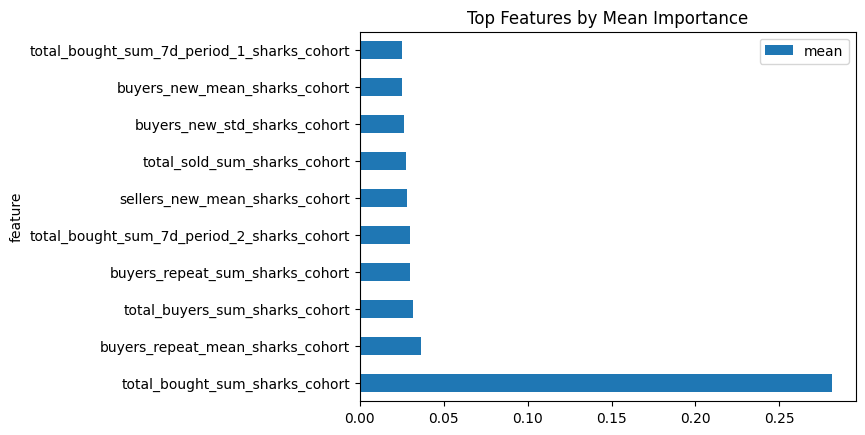

In [142]:
importlib.reload(td)
importlib.reload(cwm)
importlib.reload(fe)
importlib.reload(m)
importlib.reload(i)
config = load_config('../config/config.yaml')
metrics_config = load_config('../config/metrics_config.yaml')
modeling_config = load_config('../config/modeling_config.yaml')


modeling_folder = modeling_config['modeling']['modeling_folder']
experiment_id = "more_sharks_131bff29-dafa-4e56-ae14-2862a22b5304"

# 1. Construct the path to the experiment metadata file
experiment_metadata_path = os.path.join(modeling_folder, "experiment_metadata", f"{experiment_id}.json")
with open(experiment_metadata_path, 'r') as f:
    experiment_metadata = json.load(f)

# Retrieve trial log filenames
trial_logs = experiment_metadata['trial_logs']


# Initialize an empty list to store DataFrames
all_feature_importances = []

# Loop through each trial log and process feature importance
for trial_log_path in trial_logs:
    with open(trial_log_path, 'r') as f:
        trial_log_data = json.load(f)
    
    # Extract feature importance and convert to DataFrame
    feature_importance = trial_log_data['feature_importance']
    feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])
    
    # Append the DataFrame to the list
    all_feature_importances.append(feature_importance_df)

# Concatenate all DataFrames
combined_feature_importance_df = pd.concat(all_feature_importances)

# Group by feature and calculate mean importance
feature_stats = combined_feature_importance_df.groupby('feature')['importance'].agg(['mean', 'var', 'std']).reset_index()

# Sort by mean importance and display top features
sorted_features = feature_stats.sort_values(by='mean', ascending=False)
print(sorted_features.head())

# Plot the top features by importance
sorted_features.head(10).plot(kind='barh', x='feature', y='mean', title='Top Features by Mean Importance')

In [59]:
performance_metrics

{}

In [67]:

# Initialize lists to store the data
trial_data = []

# Loop through each trial log and extract trial_overrides and performance metrics
for trial_log_path in trial_logs:
    with open(trial_log_path, 'r') as f:
        trial_log_data = json.load(f)
    
    # Extract trial_overrides and performance metrics
    trial_overrides = trial_log_data.get('trial_overrides', {})
    performance_metrics = trial_log_data.get('metrics', {})

    # Merge trial_overrides and performance metrics into a single dictionary
    trial_info = {**trial_overrides, **performance_metrics}
    
    # Append trial info to the list
    trial_data.append(trial_info)

# Convert the list of dictionaries to a pandas DataFrame
trial_df = pd.DataFrame(trial_data)

trial_df

,modeling_config.target_variables.moon_threshold,modeling_config.preprocessing.drop_features,modeling_config.modeling.model_params.n_estimators,metrics_config.metrics.sellers_new.aggregations.sum.scaling,metrics_config.metrics.sellers_new.aggregations.mean.scaling,metrics_config.metrics.buyers_repeat.aggregations.sum.scaling,metrics_config.metrics.buyers_repeat.aggregations.mean.scaling,metrics_config.metrics.buyers_new.aggregations.sum.scaling,metrics_config.metrics.buyers_new.aggregations.median.scaling,config.wallet_cohorts.sharks.wallet_minimum_inflows,config.wallet_cohorts.sharks.wallet_min_coin_wins,config.wallet_cohorts.sharks.coin_return_win_threshold,config.wallet_cohorts.sharks.coin_profits_win_threshold,accuracy,precision,recall,f1_score,roc_auc,log_loss,confusion_matrix
0,0.3,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,standard,standard,None,5000,5,0.65,7000,0.4,0.666666666667,0.5,0.571428571429,0.25,0.722902708075,"[[0, 1], [2, 2]]"
1,0.5,[total_sellers_sum],50,standard,minmax,standard,standard,standard,None,5000,5,0.65,7000,0.6,0,0,0,0.583333333333,0.62598108161,"[[3, 0], [2, 0]]"
2,0.5,[total_sellers_sum],50,standard,minmax,standard,minmax,standard,None,15000,3,0.4,2000,0.789473684211,0.333333333333,0.333333333333,0.333333333333,0.541666666667,0.535203779122,"[[14, 2], [2, 1]]"
3,0.5,[total_sellers_sum],50,standard,minmax,standard,minmax,standard,None,15000,5,0.4,7000,0.6,0,0,0,0.583333333333,0.62598108161,"[[3, 0], [2, 0]]"
4,0.5,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,standard,standard,None,15000,5,0.4,7000,0.6,0,0,0,0.583333333333,0.600750824545,"[[3, 0], [2, 0]]"
5,0.5,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,minmax,standard,None,5000,3,0.65,2000,0.684210526316,0.2,0.333333333333,0.25,0.614583333333,0.506573220626,"[[12, 4], [2, 1]]"
6,0.3,[total_sellers_sum],50,standard,minmax,standard,standard,standard,None,5000,5,0.65,2000,0.611111111111,0.666666666667,0.6,0.631578947368,0.44375,0.847182159922,"[[5, 3], [4, 6]]"
7,0.5,[total_sellers_sum],50,standard,standard,standard,standard,standard,None,15000,5,0.4,2000,0.684210526316,0.333333333333,0.2,0.25,0.407142857143,0.73265595723,"[[12, 2], [4, 1]]"
8,0.3,[total_sellers_sum],50,standard,standard,standard,minmax,standard,None,5000,3,0.65,7000,0.647058823529,0.625,0.625,0.625,0.680555555556,0.658866090983,"[[6, 3], [3, 5]]"
9,0.5,[total_sellers_sum],50,standard,standard,standard,standard,standard,None,15000,3,0.4,7000,0.75,0.75,0.5,0.6,0.683333333333,0.626665900236,"[[9, 1], [3, 3]]"


In [68]:
# Select columns that are numeric for correlation analysis
numeric_cols = [
    'modeling_config.target_variables.moon_threshold',
    'modeling_config.modeling.model_params.n_estimators',
    'config.wallet_cohorts.sharks.wallet_minimum_inflows',
    'config.wallet_cohorts.sharks.wallet_min_coin_wins',
    'config.wallet_cohorts.sharks.coin_return_win_threshold',
    'config.wallet_cohorts.sharks.coin_profits_win_threshold',
    'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'log_loss'
]

# Compute the correlation matrix
correlation_matrix = trial_df[numeric_cols].corr()

# Display the correlation matrix
correlation_matrix

,modeling_config.target_variables.moon_threshold,modeling_config.modeling.model_params.n_estimators,config.wallet_cohorts.sharks.wallet_minimum_inflows,config.wallet_cohorts.sharks.wallet_min_coin_wins,config.wallet_cohorts.sharks.coin_return_win_threshold,config.wallet_cohorts.sharks.coin_profits_win_threshold,accuracy,precision,recall,f1_score,roc_auc,log_loss
modeling_config.target_variables.moon_threshold,1,-0.047619047619,0.654653670708,-0.0890870806375,-0.654653670708,-0.0890870806375,0.54501561066,-0.672522334102,-0.737378956577,-0.728021874304,0.405800427425,-0.657390075533
modeling_config.modeling.model_params.n_estimators,-0.047619047619,1,-0.218217890236,0.0890870806375,0.218217890236,0.0890870806375,-0.488617601341,-0.156268124669,-0.0870677346846,-0.134509849163,-0.279762789438,-0.265161599647
config.wallet_cohorts.sharks.wallet_minimum_inflows,0.654653670708,-0.218217890236,1,8.80031756925e-17,-1,-5.03779374868e-17,0.477685237148,-0.258031722228,-0.434303731221,-0.351319121617,0.177787857905,-0.254734061226
config.wallet_cohorts.sharks.wallet_min_coin_wins,-0.0890870806375,0.0890870806375,8.80031756925e-17,1,-2.03960993327e-16,0.166666666667,-0.657032555927,-0.339695165418,-0.48001748525,-0.403819076598,-0.595366055579,0.575268747731
config.wallet_cohorts.sharks.coin_return_win_threshold,-0.654653670708,0.218217890236,-1,-2.03960993327e-16,1,8.5863045724e-17,-0.477685237148,0.258031722228,0.434303731221,0.351319121617,-0.177787857905,0.254734061226
config.wallet_cohorts.sharks.coin_profits_win_threshold,-0.0890870806375,0.0890870806375,-5.03779374868e-17,0.166666666667,8.5863045724e-17,1,-0.450923689249,-0.0733836245852,-0.198926165059,-0.12854952472,0.226261345915,-0.0617048459864
accuracy,0.54501561066,-0.488617601341,0.477685237148,-0.657032555927,-0.477685237148,-0.450923689249,1,-0.0235216780785,0.0251205601948,-0.00771429465116,0.634776261943,-0.438924447533
precision,-0.672522334102,-0.156268124669,-0.258031722228,-0.339695165418,0.258031722228,-0.0733836245852,-0.0235216780785,1,0.940685654937,0.985198814312,-0.22004952371,0.497482628295
recall,-0.737378956577,-0.0870677346846,-0.434303731221,-0.48001748525,0.434303731221,-0.198926165059,0.0251205601948,0.940685654937,1,0.984038953057,-0.117805855864,0.379269205808
f1_score,-0.728021874304,-0.134509849163,-0.351319121617,-0.403819076598,0.351319121617,-0.12854952472,-0.00771429465116,0.985198814312,0.984038953057,1,-0.176305425806,0.457571550161


In [69]:
# Group by key parameter columns and calculate mean performance metrics
group_by_params = [
    'config.wallet_cohorts.sharks.wallet_minimum_inflows',
    'config.wallet_cohorts.sharks.wallet_min_coin_wins',
    'modeling_config.target_variables.moon_threshold'
]

# Calculate mean of performance metrics for each group
grouped_metrics = trial_df.groupby(group_by_params)[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].mean()

# Display the grouped metrics
grouped_metrics

accuracy  \
config.wallet_cohorts.sharks.wallet_minimum_inf... config.wallet_cohorts.sharks.wallet_min_coin_wins modeling_config.target_variables.moon_threshold                  
5000                                               3                                                 0.3                                             0.647058823529   
                                                                                                     0.5                                             0.684210526316   
                                                   5                                                 0.3                                             0.505555555556   
                                                                                                     0.5                                                        0.6   
15000                                              3                                                 0.5                                             0.769736842105   
                                                   5                                                 0.5                                             0.628070175439   

                                                                                                                                                          precision  \
config.wallet_cohorts.sharks.wallet_minimum_inf... config.wallet_cohorts.sharks.wallet_min_coin_wins modeling_config.target_variables.moon_threshold                  
5000                                               3                                                 0.3                                                      0.625   
                                                                                                     0.5                                                        0.2   
                                                   5                                                 0.3                                             0.666666666667   
                                                                                                     0.5                                                          0   
15000                                              3                                                 0.5                                             0.541666666667   
                                                   5                                                 0.5                                             0.111111111111   

                                                                                                                                                              recall  \
config.wallet_cohorts.sharks.wallet_minimum_inf... config.wallet_cohorts.sharks.wallet_min_coin_wins modeling_config.target_variables.moon_threshold                   
5000                                               3                                                 0.3                                                       0.625   
                                                                                                     0.5                                              0.333333333333   
                                                   5                                                 0.3                                                        0.55   
                                                                                                     0.5                                                           0   
15000                                              3                                                 0.5                                              0.416666666667   
                                                   5                                                 0.5                                             0.0666666666667   

                                                                                                                                        

In [144]:

# 1. Construct the path to the experiment metadata file
experiment_metadata_path = os.path.join(modeling_folder, "experiment_metadata", f"{experiment_id}.json")

# Load the experiment metadata to retrieve trial logs
with open(experiment_metadata_path, 'r') as f:
    experiment_metadata = json.load(f)

# Retrieve trial log filenames
trial_logs = experiment_metadata['trial_logs']

# Initialize an empty list to store DataFrames
all_feature_importances = []

# Loop through each trial log and process feature importance
for trial_log_path in trial_logs:
    with open(trial_log_path, 'r') as f:
        trial_log_data = json.load(f)
    
    # Extract feature importance and convert to DataFrame
    feature_importance = trial_log_data['feature_importance']
    feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])
    
    # Append the DataFrame to the list
    all_feature_importances.append(feature_importance_df)

# Concatenate all DataFrames
combined_feature_importance_df = pd.concat(all_feature_importances)

# Group by feature and calculate mean importance
feature_stats = combined_feature_importance_df.groupby('feature')['importance'].agg(['mean', 'var', 'std']).reset_index()

# Sort by mean importance
sorted_features = feature_stats.sort_values(by='mean', ascending=False)


In [145]:
feature_stats

,feature,mean,var,std
0,buyers_new_change_7d_period_1_sharks_cohort,0.00901420612132,9.85705014601e-05,0.00992826779756
1,buyers_new_change_7d_period_2_sharks_cohort,0.00486332858645,4.17523650727e-05,0.00646160700389
2,buyers_new_change_7d_period_3_sharks_cohort,0.00436742510694,2.38169398185e-05,0.00488026022037
3,buyers_new_change_7d_period_4_sharks_cohort,0.00339560994733,1.80629064638e-05,0.00425004781901
4,buyers_new_change_7d_period_5_sharks_cohort,0.00489452543482,2.52658240523e-05,0.00502651211601
...,...,...,...,...
57,total_bought_sum_7d_period_7_sharks_cohort,0.0180142261614,0.00028873925489,0.0169923292956
58,total_bought_sum_7d_period_8_sharks_cohort,0.0243531636648,0.000271720267441,0.016483939682
59,total_bought_sum_sharks_cohort,0.281525749199,0.0857574050069,0.292843652837
60,total_buyers_sum_sharks_cohort,0.0318294548336,0.000320781303071,0.0179103685911


In [146]:
sorted_features

,feature,mean,var,std
59,total_bought_sum_sharks_cohort,0.281525749199,0.0857574050069,0.292843652837
36,buyers_repeat_mean_sharks_cohort,0.036693963854,8.35075899825e-05,0.00913824873718
60,total_buyers_sum_sharks_cohort,0.0318294548336,0.000320781303071,0.0179103685911
38,buyers_repeat_sum_sharks_cohort,0.0301004285693,0.000292681462956,0.017107935672
52,total_bought_sum_7d_period_2_sharks_cohort,0.0295586848799,0.00017746919998,0.0133217566402
...,...,...,...,...
37,buyers_repeat_median_sharks_cohort,0.00139255472739,5.29607612474e-06,0.0023013205176
21,buyers_new_pct_change_7d_period_4_sharks_cohort,0.000830795882077,2.48135277383e-06,0.00157523102237
24,buyers_new_pct_change_7d_period_7_sharks_cohort,0.000606284747388,1.77159790903e-06,0.00133101386508
40,sellers_new_median_sharks_cohort,0.000382189304485,6.93436293054e-07,0.000832728222804


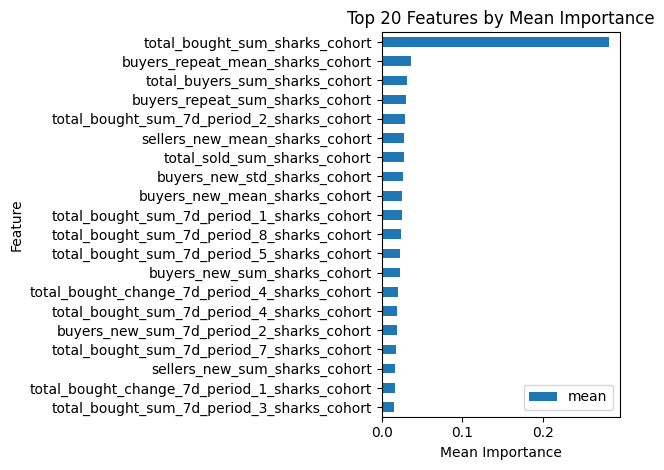

In [147]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_feature_importance(modeling_folder, experiment_id, top_n=10):
    """
    Plot the top features by mean importance from an experiment's feature importance logs.

    Parameters:
    - modeling_folder: str, path to the folder where the experiment data is stored.
    - experiment_id: str, unique identifier for the experiment to retrieve the logs.
    - top_n: int, number of top features to display in the bar chart (default: 10).
    
    This function retrieves trial logs from an experiment's metadata, extracts feature importance 
    data, calculates the mean importance across all trials, and displays a bar chart of the top_n 
    most important features.
    """
    # 1. Construct the path to the experiment metadata file
    experiment_metadata_path = os.path.join(modeling_folder, "experiment_metadata", f"{experiment_id}.json")
    
    # Load the experiment metadata to retrieve trial logs
    with open(experiment_metadata_path, 'r') as f:
        experiment_metadata = json.load(f)
    
    # Retrieve trial log filenames
    trial_logs = experiment_metadata['trial_logs']
    
    # Initialize an empty list to store DataFrames
    all_feature_importances = []
    
    # Loop through each trial log and process feature importance
    for trial_log_path in trial_logs:
        with open(trial_log_path, 'r') as f:
            trial_log_data = json.load(f)
        
        # Extract feature importance and convert to DataFrame
        feature_importance = trial_log_data['feature_importance']
        feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])
        
        # Append the DataFrame to the list
        all_feature_importances.append(feature_importance_df)
    
    # Concatenate all DataFrames
    combined_feature_importance_df = pd.concat(all_feature_importances)
    
    # Group by feature and calculate mean importance
    feature_stats = combined_feature_importance_df.groupby('feature')['importance'].agg(['mean', 'var', 'std']).reset_index()
    
    # Sort by mean importance
    sorted_features = feature_stats.sort_values(by='mean', ascending=False)
    
    # Plot the top features by importance
    sorted_features.head(top_n).sort_values(by='mean',ascending=True).plot(kind='barh', x='feature', y='mean', title=f'Top {top_n} Features by Mean Importance')
    
    # Display the plot
    plt.xlabel('Mean Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


plot_top_feature_importance(modeling_folder, experiment_id, top_n=20)

In [148]:
import os
import json
import pandas as pd

def generate_trial_df(modeling_folder, experiment_id):
    """
    Generates a DataFrame by loading and processing trial logs from a specified modeling folder and experiment ID.
    
    Parameters:
    - modeling_folder: The path to the folder where model data is stored.
    - experiment_id: The ID of the experiment to retrieve trial logs from.
    
    Returns:
    - A pandas DataFrame (trial_df) containing the processed trial logs.
    """
    
    # 1. Construct the path to the experiment metadata file
    experiment_metadata_path = os.path.join(modeling_folder, "experiment_metadata", f"{experiment_id}.json")
    
    # 2. Load the experiment metadata
    with open(experiment_metadata_path, 'r') as f:
        experiment_metadata = json.load(f)

    # Retrieve trial log filenames
    trial_logs = experiment_metadata['trial_logs']

    # 3. Initialize lists to store trial data
    trial_data = []

    # 4. Loop through each trial log and extract relevant information
    for trial_log_path in trial_logs:
        with open(trial_log_path, 'r') as f:
            trial_log_data = json.load(f)
        
        # Extract trial_overrides and performance metrics
        trial_overrides = trial_log_data.get('trial_overrides', {})
        performance_metrics = trial_log_data.get('metrics', {})
        
        # Merge trial_overrides and performance metrics into a single dictionary
        trial_info = {**trial_overrides, **performance_metrics}
        
        # Append trial info to the list
        trial_data.append(trial_info)
    
    # 5. Convert the list of dictionaries to a pandas DataFrame
    trial_df = pd.DataFrame(trial_data)
    
    return trial_df


def plot_roc_auc_performance(trial_df, top_n):
    """
    Plot the average ROC AUC performance for the top N features in the trial_df.
    
    Parameters:
    - trial_df: DataFrame containing trial data with columns to be grouped and evaluated.
    - top_n: The number of top features based on average ROC AUC to plot.
    """
    # Ensure all columns are converted to strings to handle arrays, lists, and other non-numeric data types
    trial_df = trial_df.applymap(lambda x: str(x) if isinstance(x, (list, dict, tuple)) else x)

    # Calculate mean roc_auc for each category in the relevant columns
    roc_auc_means = pd.DataFrame()

    for column in trial_df.columns:
        if column not in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'log_loss', 'confusion_matrix']:
            grouped = trial_df.groupby(column)['roc_auc'].mean().reset_index()
            grouped['feature'] = column
            roc_auc_means = pd.concat([roc_auc_means, grouped], ignore_index=True)

    # Sort by mean ROC AUC and select the top N
    roc_auc_means = roc_auc_means.sort_values(by='roc_auc', ascending=False).head(top_n)

    # Plot the results in a single bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='roc_auc', y='feature', data=roc_auc_means)
    plt.title(f'Top {top_n} Features by ROC AUC Performance')
    plt.xlabel('Average ROC AUC')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


def plot_top_feature_importance(modeling_folder, experiment_id, top_n=10):
    """
    Plot the top features by mean importance from an experiment's feature importance logs.

    Parameters:
    - modeling_folder: str, path to the folder where the experiment data is stored.
    - experiment_id: str, unique identifier for the experiment to retrieve the logs.
    - top_n: int, number of top features to display in the bar chart (default: 10).
    
    This function retrieves trial logs from an experiment's metadata, extracts feature importance 
    data, calculates the mean importance across all trials, and displays a bar chart of the top_n 
    most important features.
    """
    # 1. Construct the path to the experiment metadata file
    experiment_metadata_path = os.path.join(modeling_folder, "experiment_metadata", f"{experiment_id}.json")
    
    # Load the experiment metadata to retrieve trial logs
    with open(experiment_metadata_path, 'r') as f:
        experiment_metadata = json.load(f)
    
    # Retrieve trial log filenames
    trial_logs = experiment_metadata['trial_logs']
    
    # Initialize an empty list to store DataFrames
    all_feature_importances = []
    
    # Loop through each trial log and process feature importance
    for trial_log_path in trial_logs:
        with open(trial_log_path, 'r') as f:
            trial_log_data = json.load(f)
        
        # Extract feature importance and convert to DataFrame
        feature_importance = trial_log_data['feature_importance']
        feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])
        
        # Append the DataFrame to the list
        all_feature_importances.append(feature_importance_df)
    
    # Concatenate all DataFrames
    combined_feature_importance_df = pd.concat(all_feature_importances)
    
    # Group by feature and calculate mean importance
    feature_stats = combined_feature_importance_df.groupby('feature')['importance'].agg(['mean', 'var', 'std']).reset_index()
    
    # Sort by mean importance
    sorted_features = feature_stats.sort_values(by='mean', ascending=False)
    
    # Plot the top features by importance
    sorted_features.head(top_n).sort_values(by='mean',ascending=True).plot(kind='barh', x='feature', y='mean', title=f'Top {top_n} Features by Mean Importance')
    
    # Display the plot
    plt.xlabel('Mean Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()



def analyze_experiment(modeling_folder, experiment_id, top_n=10):
    """
    Analyze experiment results by generating two visualizations:
    1. A bar chart of the top N features by ROC AUC performance.
    2. A bar chart of the top N features by mean importance from the trial logs.

    Parameters:
    - modeling_folder: str, path to the folder where the experiment data is stored.
    - experiment_id: str, unique identifier for the experiment to retrieve the logs.
    - top_n: int, number of top features to display in the bar charts (default: 10).
    """
    # Generate trial DataFrame from the experiment logs
    trial_df = generate_trial_df(modeling_folder, experiment_id)
    
    # Plot ROC AUC performance for the top N features
    plot_roc_auc_performance(trial_df, top_n)
    
    # Plot top feature importance based on the trial logs
    plot_top_feature_importance(modeling_folder, experiment_id, top_n)

/var/folders/g9/sn8nm3vn7ljbdyt5ts_0qwf80000gn/T/ipykernel_86151/4202321592.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trial_df = trial_df.applymap(lambda x: str(x) if isinstance(x, (list, dict, tuple)) else x)


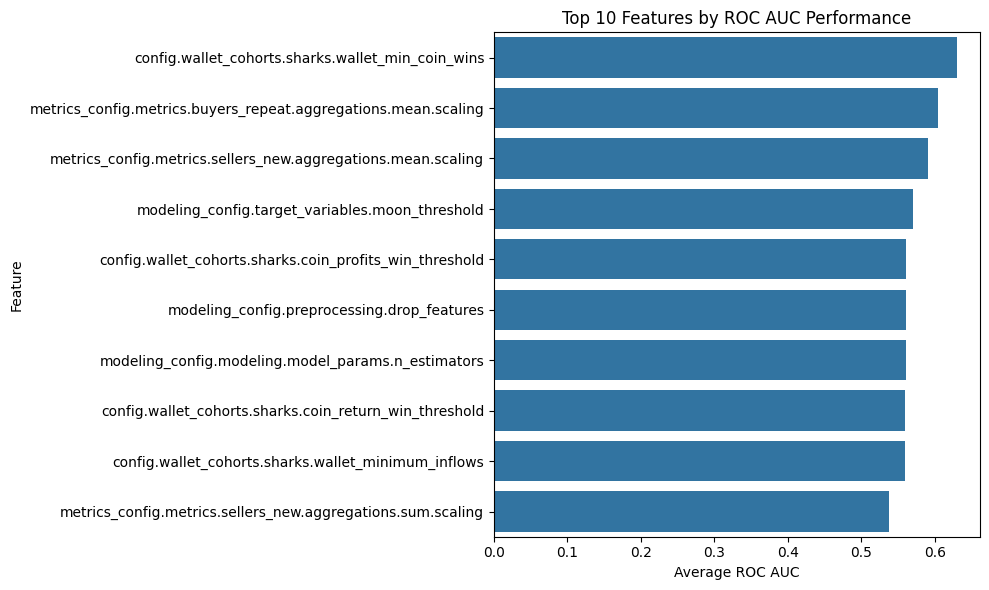

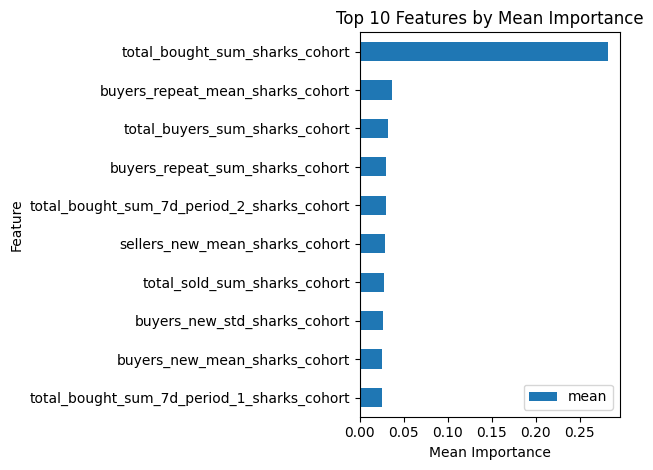

In [149]:
analyze_experiment(modeling_folder, experiment_id, top_n=10)

/var/folders/g9/sn8nm3vn7ljbdyt5ts_0qwf80000gn/T/ipykernel_86151/3651164228.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trial_df = trial_df.applymap(lambda x: str(x) if isinstance(x, (list, dict, tuple)) else x)


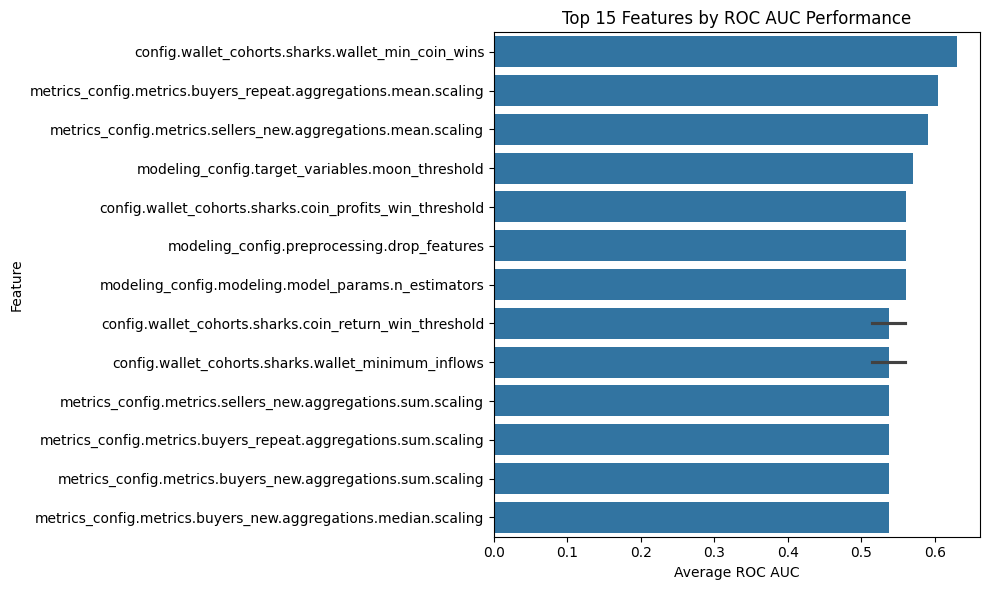

In [140]:
trial_df = generate_trial_df(modeling_folder, experiment_id)
trial_df

plot_roc_auc_performance(trial_df, 15)

In [111]:
# 1. Load necessary libraries
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load experiment metadata
modeling_folder = modeling_config['modeling']['modeling_folder']
experiment_id = "more_sharks_131bff29-dafa-4e56-ae14-2862a22b5304"

experiment_metadata_path = os.path.join(modeling_folder, "experiment_metadata", f"{experiment_id}.json")
with open(experiment_metadata_path, 'r') as f:
    experiment_metadata = json.load(f)

# 3. Retrieve trial logs
trial_logs = experiment_metadata['trial_logs']

# Initialize lists to store both trial data and feature importances
trial_data = []
all_feature_importances = []

# 4. Loop through each trial log once, processing both feature importance and trial metrics
for trial_log_path in trial_logs:
    with open(trial_log_path, 'r') as f:
        trial_log_data = json.load(f)
    
    # Process feature importance
    feature_importance = trial_log_data['feature_importance']
    feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])
    all_feature_importances.append(feature_importance_df)
    
    # Process trial data (trial_overrides and performance metrics)
    trial_overrides = trial_log_data.get('trial_overrides', {})
    performance_metrics = trial_log_data.get('metrics', {})
    trial_info = {**trial_overrides, **performance_metrics}
    trial_data.append(trial_info)

# 5. Concatenate feature importance data
combined_feature_importance_df = pd.concat(all_feature_importances)

# 6. Calculate mean feature importance and plot top 15
feature_stats = combined_feature_importance_df.groupby('feature')['importance'].agg(['mean', 'var', 'std']).reset_index()
sorted_features = feature_stats.sort_values(by='mean', ascending=False).head(15)
# sorted_features.plot(kind='barh', x='feature', y='mean', title='Top 15 Features by Mean Importance')

# 7. Convert trial data into a DataFrame
trial_df = pd.DataFrame(trial_data)

# 8. Filter trial_df to match top 15 features
top_features = sorted_features['feature'].tolist()
trial_df_top_features = trial_df[top_features + ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'log_loss']]

# 9. Correlation matrix of top 15 features and performance metrics
numeric_columns = trial_df_top_features.applymap(lambda x: isinstance(x, (int, float))).all(0)
numeric_trial_df = trial_df_top_features.loc[:, numeric_columns]

corr_matrix = numeric_trial_df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix of Top 15 Features and Performance Metrics')
# plt.show()

KeyError: "['total_bought_sum_sharks_cohort', 'buyers_repeat_mean_sharks_cohort', 'total_buyers_sum_sharks_cohort', 'buyers_repeat_sum_sharks_cohort', 'total_bought_sum_7d_period_2_sharks_cohort', 'sellers_new_mean_sharks_cohort', 'total_sold_sum_sharks_cohort', 'buyers_new_std_sharks_cohort', 'buyers_new_mean_sharks_cohort', 'total_bought_sum_7d_period_1_sharks_cohort', 'total_bought_sum_7d_period_8_sharks_cohort', 'total_bought_sum_7d_period_5_sharks_cohort', 'buyers_new_sum_sharks_cohort', 'total_bought_change_7d_period_4_sharks_cohort', 'total_bought_sum_7d_period_4_sharks_cohort'] not in index"

In [112]:
top_features

['total_bought_sum_sharks_cohort',
 'buyers_repeat_mean_sharks_cohort',
 'total_buyers_sum_sharks_cohort',
 'buyers_repeat_sum_sharks_cohort',
 'total_bought_sum_7d_period_2_sharks_cohort',
 'sellers_new_mean_sharks_cohort',
 'total_sold_sum_sharks_cohort',
 'buyers_new_std_sharks_cohort',
 'buyers_new_mean_sharks_cohort',
 'total_bought_sum_7d_period_1_sharks_cohort',
 'total_bought_sum_7d_period_8_sharks_cohort',
 'total_bought_sum_7d_period_5_sharks_cohort',
 'buyers_new_sum_sharks_cohort',
 'total_bought_change_7d_period_4_sharks_cohort',
 'total_bought_sum_7d_period_4_sharks_cohort']

In [113]:
trial_df

,modeling_config.target_variables.moon_threshold,modeling_config.preprocessing.drop_features,modeling_config.modeling.model_params.n_estimators,metrics_config.metrics.sellers_new.aggregations.sum.scaling,metrics_config.metrics.sellers_new.aggregations.mean.scaling,metrics_config.metrics.buyers_repeat.aggregations.sum.scaling,metrics_config.metrics.buyers_repeat.aggregations.mean.scaling,metrics_config.metrics.buyers_new.aggregations.sum.scaling,metrics_config.metrics.buyers_new.aggregations.median.scaling,config.wallet_cohorts.sharks.wallet_minimum_inflows,config.wallet_cohorts.sharks.wallet_min_coin_wins,config.wallet_cohorts.sharks.coin_return_win_threshold,config.wallet_cohorts.sharks.coin_profits_win_threshold,accuracy,precision,recall,f1_score,roc_auc,log_loss,confusion_matrix
0,0.3,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,standard,standard,None,5000,5,0.65,7000,0.4,0.666666666667,0.5,0.571428571429,0.25,0.722902708075,"[[0, 1], [2, 2]]"
1,0.5,[total_sellers_sum],50,standard,minmax,standard,standard,standard,None,5000,5,0.65,7000,0.6,0,0,0,0.583333333333,0.62598108161,"[[3, 0], [2, 0]]"
2,0.5,[total_sellers_sum],50,standard,minmax,standard,minmax,standard,None,15000,3,0.4,2000,0.789473684211,0.333333333333,0.333333333333,0.333333333333,0.541666666667,0.535203779122,"[[14, 2], [2, 1]]"
3,0.5,[total_sellers_sum],50,standard,minmax,standard,minmax,standard,None,15000,5,0.4,7000,0.6,0,0,0,0.583333333333,0.62598108161,"[[3, 0], [2, 0]]"
4,0.5,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,standard,standard,None,15000,5,0.4,7000,0.6,0,0,0,0.583333333333,0.600750824545,"[[3, 0], [2, 0]]"
5,0.5,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,minmax,standard,None,5000,3,0.65,2000,0.684210526316,0.2,0.333333333333,0.25,0.614583333333,0.506573220626,"[[12, 4], [2, 1]]"
6,0.3,[total_sellers_sum],50,standard,minmax,standard,standard,standard,None,5000,5,0.65,2000,0.611111111111,0.666666666667,0.6,0.631578947368,0.44375,0.847182159922,"[[5, 3], [4, 6]]"
7,0.5,[total_sellers_sum],50,standard,standard,standard,standard,standard,None,15000,5,0.4,2000,0.684210526316,0.333333333333,0.2,0.25,0.407142857143,0.73265595723,"[[12, 2], [4, 1]]"
8,0.3,[total_sellers_sum],50,standard,standard,standard,minmax,standard,None,5000,3,0.65,7000,0.647058823529,0.625,0.625,0.625,0.680555555556,0.658866090983,"[[6, 3], [3, 5]]"
9,0.5,[total_sellers_sum],50,standard,standard,standard,standard,standard,None,15000,3,0.4,7000,0.75,0.75,0.5,0.6,0.683333333333,0.626665900236,"[[9, 1], [3, 3]]"


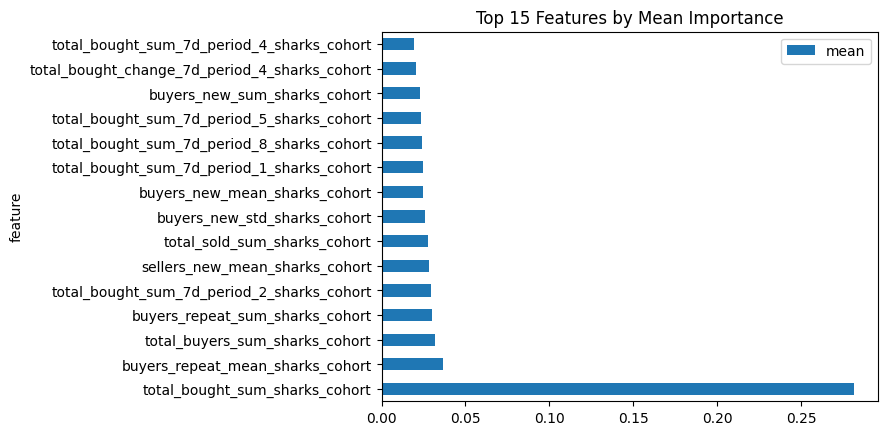

In [101]:
feature_stats

,feature,mean
0,buyers_new_change_7d_period_1_sharks_cohort,0.00901420612132
1,buyers_new_change_7d_period_2_sharks_cohort,0.00486332858645
2,buyers_new_change_7d_period_3_sharks_cohort,0.00436742510694
3,buyers_new_change_7d_period_4_sharks_cohort,0.00339560994733
4,buyers_new_change_7d_period_5_sharks_cohort,0.00489452543482
...,...,...
57,total_bought_sum_7d_period_7_sharks_cohort,0.0180142261614
58,total_bought_sum_7d_period_8_sharks_cohort,0.0243531636648
59,total_bought_sum_sharks_cohort,0.281525749199
60,total_buyers_sum_sharks_cohort,0.0318294548336


/var/folders/g9/sn8nm3vn7ljbdyt5ts_0qwf80000gn/T/ipykernel_86151/710634143.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='roc_auc', y='feature', data=roc_auc_means, palette='Blues_d')


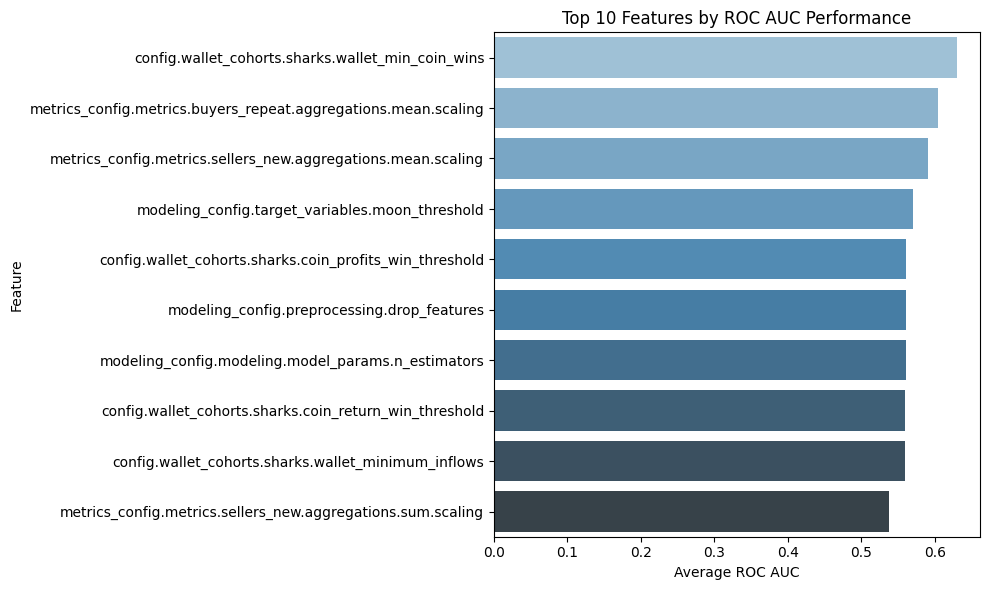

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot ROC AUC performance for top_n features
def plot_roc_auc_performance(trial_df, top_n):
    """
    Plot the average ROC AUC performance for the top N features in the trial_df.
    
    Parameters:
    - trial_df: DataFrame containing trial data with columns to be grouped and evaluated.
    - top_n: The number of top features based on average ROC AUC to plot.
    """
    # Calculate mean roc_auc for each category in the relevant columns
    roc_auc_means = pd.DataFrame()

    for column in trial_df.columns:
        if column not in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'log_loss', 'confusion_matrix']:
            grouped = trial_df.groupby(column)['roc_auc'].mean().reset_index()
            grouped['feature'] = column
            roc_auc_means = pd.concat([roc_auc_means, grouped], ignore_index=True)

    # Sort by mean ROC AUC and select the top N
    roc_auc_means = roc_auc_means.sort_values(by='roc_auc', ascending=False).head(top_n)

    # Plot the results in a single bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='roc_auc', y='feature', data=roc_auc_means, palette='Blues_d')
    plt.title(f'Top {top_n} Features by ROC AUC Performance')
    plt.xlabel('Average ROC AUC')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


plot_roc_auc_performance(trial_df, 10)

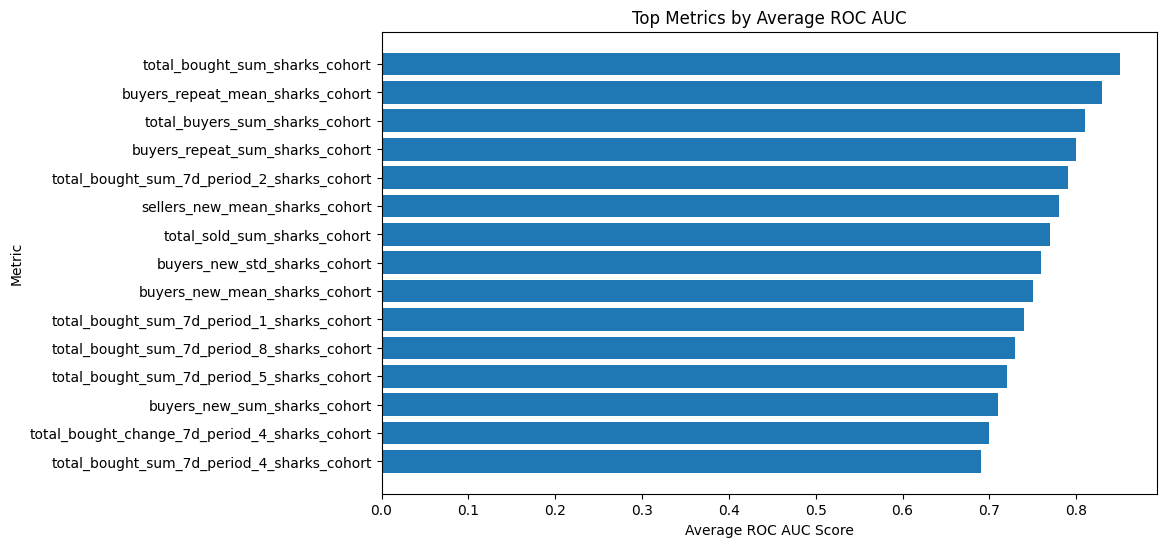

In [120]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for metrics and their average ROC AUC scores (sorted)
data = {
    'Metric': [
        'total_bought_sum_sharks_cohort', 'buyers_repeat_mean_sharks_cohort', 
        'total_buyers_sum_sharks_cohort', 'buyers_repeat_sum_sharks_cohort', 
        'total_bought_sum_7d_period_2_sharks_cohort', 'sellers_new_mean_sharks_cohort', 
        'total_sold_sum_sharks_cohort', 'buyers_new_std_sharks_cohort', 
        'buyers_new_mean_sharks_cohort', 'total_bought_sum_7d_period_1_sharks_cohort',
        'total_bought_sum_7d_period_8_sharks_cohort', 'total_bought_sum_7d_period_5_sharks_cohort',
        'buyers_new_sum_sharks_cohort', 'total_bought_change_7d_period_4_sharks_cohort',
        'total_bought_sum_7d_period_4_sharks_cohort'
    ],
    'Avg_ROC_AUC': [0.85, 0.83, 0.81, 0.80, 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.70, 0.69]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Sort the DataFrame by ROC AUC scores in descending order
df_sorted = df.sort_values(by='Avg_ROC_AUC', ascending=False)

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Metric'], df_sorted['Avg_ROC_AUC'])
plt.xlabel('Average ROC AUC Score')
plt.ylabel('Metric')
plt.title('Top Metrics by Average ROC AUC')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()

In [117]:
for column in trial_df.columns:
    if column != 'roc_auc':
        # Group by column and calculate mean roc_auc for each group
        grouped = trial_df.groupby(column)['roc_auc'].mean().reset_index()
        

TypeError: unhashable type: 'list'

In [118]:
trial_df

,modeling_config.target_variables.moon_threshold,modeling_config.preprocessing.drop_features,modeling_config.modeling.model_params.n_estimators,metrics_config.metrics.sellers_new.aggregations.sum.scaling,metrics_config.metrics.sellers_new.aggregations.mean.scaling,metrics_config.metrics.buyers_repeat.aggregations.sum.scaling,metrics_config.metrics.buyers_repeat.aggregations.mean.scaling,metrics_config.metrics.buyers_new.aggregations.sum.scaling,metrics_config.metrics.buyers_new.aggregations.median.scaling,config.wallet_cohorts.sharks.wallet_minimum_inflows,config.wallet_cohorts.sharks.wallet_min_coin_wins,config.wallet_cohorts.sharks.coin_return_win_threshold,config.wallet_cohorts.sharks.coin_profits_win_threshold,accuracy,precision,recall,f1_score,roc_auc,log_loss,confusion_matrix
0,0.3,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,standard,standard,None,5000,5,0.65,7000,0.4,0.666666666667,0.5,0.571428571429,0.25,0.722902708075,"[[0, 1], [2, 2]]"
1,0.5,[total_sellers_sum],50,standard,minmax,standard,standard,standard,None,5000,5,0.65,7000,0.6,0,0,0,0.583333333333,0.62598108161,"[[3, 0], [2, 0]]"
2,0.5,[total_sellers_sum],50,standard,minmax,standard,minmax,standard,None,15000,3,0.4,2000,0.789473684211,0.333333333333,0.333333333333,0.333333333333,0.541666666667,0.535203779122,"[[14, 2], [2, 1]]"
3,0.5,[total_sellers_sum],50,standard,minmax,standard,minmax,standard,None,15000,5,0.4,7000,0.6,0,0,0,0.583333333333,0.62598108161,"[[3, 0], [2, 0]]"
4,0.5,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,standard,standard,None,15000,5,0.4,7000,0.6,0,0,0,0.583333333333,0.600750824545,"[[3, 0], [2, 0]]"
5,0.5,"[total_sellers_sum, buyers_new_median]",100,standard,minmax,standard,minmax,standard,None,5000,3,0.65,2000,0.684210526316,0.2,0.333333333333,0.25,0.614583333333,0.506573220626,"[[12, 4], [2, 1]]"
6,0.3,[total_sellers_sum],50,standard,minmax,standard,standard,standard,None,5000,5,0.65,2000,0.611111111111,0.666666666667,0.6,0.631578947368,0.44375,0.847182159922,"[[5, 3], [4, 6]]"
7,0.5,[total_sellers_sum],50,standard,standard,standard,standard,standard,None,15000,5,0.4,2000,0.684210526316,0.333333333333,0.2,0.25,0.407142857143,0.73265595723,"[[12, 2], [4, 1]]"
8,0.3,[total_sellers_sum],50,standard,standard,standard,minmax,standard,None,5000,3,0.65,7000,0.647058823529,0.625,0.625,0.625,0.680555555556,0.658866090983,"[[6, 3], [3, 5]]"
9,0.5,[total_sellers_sum],50,standard,standard,standard,standard,standard,None,15000,3,0.4,7000,0.75,0.75,0.5,0.6,0.683333333333,0.626665900236,"[[9, 1], [3, 3]]"
